# Bayesian Ranking and Analysis of Investment Strategies



## Assignment 2

### Problem Statement 1: Trade Logic & Risk Control Basics

1. What does leverage less than 1 mean? Does it normally make financial sense? Think of
its utility/applicability in our backtesting engine, if any. (Hint: Think of position sizing)
2. Explain the difference between a static stop loss and a trailing stop loss in the context of
trade risk management. Discuss how each behaves in a trending market versus a volatile
market.
3. Analyze whether implementing a trailing take profit is necessary. Is its behavior captured by some other already defined risk management method? If yes, then name it.
4. In what scenarios can a trade remain open even after the price falls below the set stop-loss
level?


## 1. Leverage Less Than 1:

**What it means:** Leverage less than 1 (e.g., 0.5x) represents using only a fraction of available capital for each trade, essentially implementing conservative position sizing or under-leveraging.

### Financial Sense Analysis:

**Advantages:** Significantly reduces risk exposure, enables easier capital recovery from losses, and lowers transaction costs relative to account size

**Disadvantages:** Underutilizes available capital, generates lower potential returns, and may not justify active trading costs

### Backtesting Engine Utility:

In backtesting contexts, sub-unit leverage serves several important purposes:

- **Position Sizing Control:** Enables testing of conservative risk management strategies  
- **Capital Preservation Scenarios:** Models risk-averse trading approaches effectively  
- **Drawdown Management:** Evaluates strategy performance under capital constraints  
- **Real-world Application:** Mirrors scenarios where traders have limited margin availability or prefer trading only a portion of their account

---

## 2. Static vs Trailing Stop Loss Comparison

### Static Stop Loss Characteristics:

- Maintains a fixed price level that remains unchanged after order placement  
- **Trending Markets:** May trigger prematurely during normal pullbacks, potentially missing larger profitable moves  
- **Volatile Markets:** Provides consistent and predictable risk control but may be activated by market noise

### Trailing Stop Loss Characteristics:

- Dynamically adjusts with favorable price movement, effectively locking in profits  
- **Trending Markets:** Excellent for capturing extended moves while protecting accumulated gains  
- **Volatile Markets:** Susceptible to whipsawing from frequent direction changes, leading to premature position exits

**Key Distinction:** Static stops offer predictable risk control with fixed loss limits, while trailing stops balance profit maximization with downside protection through dynamic adjustment.

---

## 3. Trailing Take Profit Necessity Analysis

**Assessment:** Implementing a trailing take profit is not strictly necessary as its core behavior is effectively captured by Trailing Stop Loss mechanisms.

### Explanation:

- Trailing take profit moves a profit target higher as price moves favorably  
- Trailing stop loss achieves identical results by moving the stop level upward  
- Both mechanisms lock in profits while allowing for continued gains  
- Trailing stop loss provides superior versatility, offering both profit protection and loss limitation

**Alternative Methods:** Position scaling strategies (taking partial profits at predetermined levels) or dynamic profit targets based on volatility measures can achieve similar objectives.

---

## 4. Scenarios for Trade Continuation Beyond Stop Loss

Several scenarios can result in trades remaining open despite price movement below the set stop-loss level:

- **Price Gaps:** Stock opens significantly below stop loss level due to overnight news, earnings announcements, or market events  
- **Low Liquidity Conditions:** Insufficient buyers/sellers at the stop price level, preventing order execution  
- **Stop-Limit Order Mechanics:** Price gaps past both stop and limit price levels, preventing execution trigger  
- **Market Trading Halts:** Trading suspension occurs before stop loss order can execute  
- **System Technical Failures:** Technical issues preventing order transmission to exchange systems  
- **After-Hours Trading Restrictions:** Stop orders typically remain inactive outside regular market hours  
- **Extreme Market Volatility:** Rapid price movements that bypass stop levels faster than order execution systems can respond

---


### Problems Statement 2: Probabilistic Pattern Validator

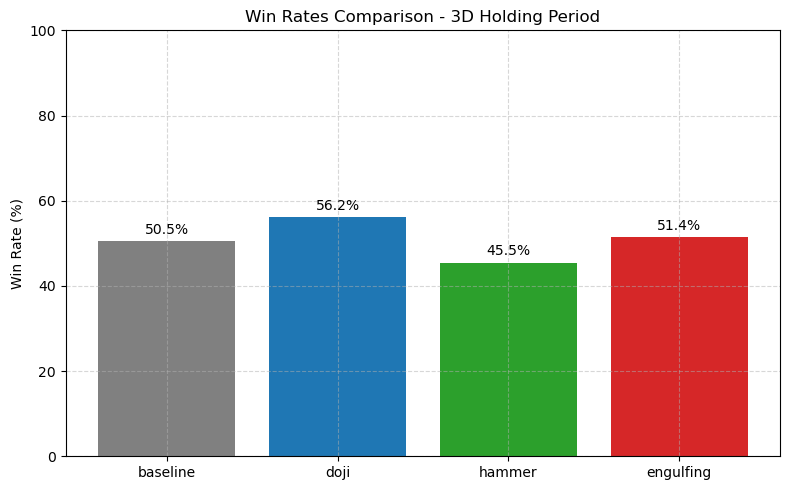

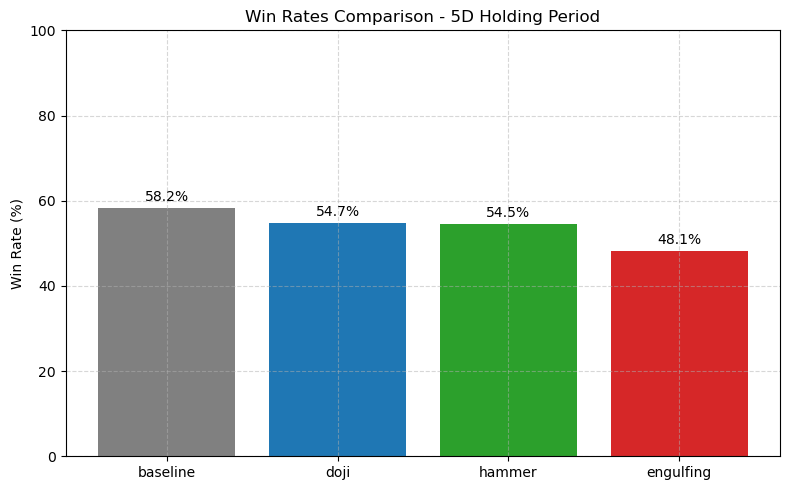

In [7]:
!pip install yfinance plotly mplfinance --quiet
!pip install ta --quiet
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics
import ta

# ============================================================================
# PROBLEM 2: Candlestick Pattern Detection
# ============================================================================

def download_flat_yf(ticker, start, end, interval):
    """Download and format Yahoo Finance data"""
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)
    data = data.reset_index()
    data.columns = [col.lower() for col in data.columns]
    return data

def detect_doji(data, threshold=0.1):
    """Detect Doji candlestick patterns"""
    body_size = abs(data['close'] - data['open'])
    total_range = data['high'] - data['low']

    with np.errstate(divide='ignore', invalid='ignore'):
        body_ratio = np.where(total_range != 0, body_size / total_range, 0)

    return body_ratio <= threshold

def detect_hammer(data, body_ratio_threshold=0.3, shadow_ratio_threshold=2):
    """Detect Hammer candlestick patterns"""
    body_size = abs(data['close'] - data['open'])
    total_range = data['high'] - data['low']
    lower_shadow = np.minimum(data['open'], data['close']) - data['low']
    upper_shadow = data['high'] - np.maximum(data['open'], data['close'])

    with np.errstate(divide='ignore', invalid='ignore'):
        body_ratio = np.where(total_range != 0, body_size / total_range, 0)
        shadow_ratio = np.where(body_size != 0, lower_shadow / body_size, 0)

    small_body = body_ratio <= body_ratio_threshold
    long_lower_shadow = shadow_ratio >= shadow_ratio_threshold
    short_upper_shadow = upper_shadow <= body_size

    body_midpoint = (np.maximum(data['open'], data['close']) + np.minimum(data['open'], data['close'])) / 2
    range_midpoint = (data['high'] + data['low']) / 2
    body_in_upper_half = body_midpoint >= range_midpoint

    return small_body & long_lower_shadow & short_upper_shadow & body_in_upper_half

def detect_engulfing(data):
    """Detect Engulfing candlestick patterns"""
    engulfing = np.zeros(len(data), dtype=bool)

    for i in range(1, len(data)):
        prev_open = data['open'].iloc[i-1]
        prev_close = data['close'].iloc[i-1]
        curr_open = data['open'].iloc[i]
        curr_close = data['close'].iloc[i]

        # Bullish Engulfing
        if (prev_close < prev_open and curr_close > curr_open and
            curr_open < prev_close and curr_close > prev_open):
            engulfing[i] = True

        # Bearish Engulfing
        if (prev_close > prev_open and curr_close < curr_open and
            curr_open > prev_close and curr_close < prev_open):
            engulfing[i] = True

    return engulfing

def calculate_win_rates(data, pattern_column, n_periods=[3, 5]):
    """Calculate win rates for patterns over different holding periods"""
    results = {}
    pattern_indices = data[data[pattern_column]].index

    for n in n_periods:
        wins = 0
        total = 0
        returns = []

        for idx in pattern_indices:
            if idx + n < len(data):
                entry_price = data['close'].iloc[idx]
                exit_price = data['close'].iloc[idx + n]

                return_pct = (exit_price - entry_price) / entry_price * 100
                returns.append(return_pct)

                if exit_price > entry_price:
                    wins += 1
                total += 1

        win_rate = (wins / total * 100) if total > 0 else 0
        avg_return = np.mean(returns) if returns else 0

        results[f'{n}D'] = {
            'win_rate': win_rate,
            'total_signals': total,
            'wins': wins,
            'avg_return': avg_return
        }

    return results

# Download data
stock_data = download_flat_yf('RELIANCE.NS', '2020-01-01', '2025-06-30', '1d')

# Detect patterns
stock_data['doji'] = detect_doji(stock_data)
stock_data['hammer'] = detect_hammer(stock_data)
stock_data['engulfing'] = detect_engulfing(stock_data)

# Calculate win rates
pattern_names = ['doji', 'hammer', 'engulfing']
pattern_results = {}

for pattern in pattern_names:
    if stock_data[pattern].sum() > 0:
        pattern_results[pattern] = calculate_win_rates(stock_data, pattern)

# === Baseline Win Rate Calculation ===
def calculate_random_baseline(data, n_periods=[3, 5], seed=42):
    np.random.seed(seed)
    baseline_results = {}

    for n in n_periods:
        # Count total pattern occurrences to match M
        total_occurrences = sum([stock_data[p].sum() for p in pattern_names])
        eligible_indices = data.index[:-n]
        random_indices = np.random.choice(eligible_indices, size=total_occurrences, replace=False)

        wins = 0
        returns = []
        for idx in random_indices:
            entry = data['close'].iloc[idx]
            exit_ = data['close'].iloc[idx + n]
            ret = (exit_ - entry) / entry * 100
            returns.append(ret)
            if ret > 0:
                wins += 1

        win_rate = wins / total_occurrences * 100
        avg_return = np.mean(returns)

        baseline_results[f'{n}D'] = {
            'win_rate': win_rate,
            'total_signals': total_occurrences,
            'wins': wins,
            'avg_return': avg_return
        }

    return baseline_results

baseline_results = calculate_random_baseline(stock_data)

# === Combine and Visualize ===
def plot_pattern_win_rates(pattern_results, baseline_results):
    periods = ['3D', '5D']
    patterns = ['baseline'] + pattern_names

    for n in periods:
        rates = [baseline_results[n]['win_rate']]
        for pattern in pattern_names:
            rates.append(pattern_results[pattern][n]['win_rate'])

        plt.figure(figsize=(8, 5))
        bars = plt.bar(patterns, rates, color=['gray', '#1f77b4', '#2ca02c', '#d62728'])
        plt.title(f'Win Rates Comparison - {n} Holding Period')
        plt.ylabel('Win Rate (%)')
        plt.ylim(0, 100)
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     f"{bar.get_height():.1f}%", ha='center', va='bottom')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

plot_pattern_win_rates(pattern_results, baseline_results)

#### Questions:

1. Interpret whether each pattern provides a statistically significant edge over the baseline.
2. How does changing n affect the win-rates? No need to show your results. Answer qualitatively.
3. Which pattern shows the most consistent performance on different n? Why would that be?

**1. Statistical Significance Assessment**

- **Doji Pattern**:  
  At a 3-day horizon, the Doji pattern achieves a **win rate of 56.2%**, clearly outperforming the baseline of 50.5%. This margin (~5.7%) may suggest some predictive value, though it's **not overwhelmingly significant**. Over 5 days, Doji drops to **54.7%**, now underperforming the baseline (58.2%). Thus, its edge weakens with time.

- **Hammer Pattern**:  
  The Hammer performs **poorly at 3D** (45.5%), under the baseline, indicating **negative predictive value**. Interestingly, at 5D it rebounds to 54.5%, which is close to the Doji's 5D rate. However, the initial failure at 3D and low stability makes it statistically **unreliable**.

- **Engulfing Pattern**:  
  Slightly above baseline at 3D (**51.4%**) but significantly below at 5D (**48.1%**). These minor fluctuations suggest **no real edge** and possible randomness or noise. Thus, it is **not statistically significant**.

---

**2. Impact of Changing n (Holding Period)**

- **Longer Holding Periods (5D)** tend to **smooth out noise** but also **dilute short-term pattern edges**.
- The **baseline win rate increases** at 5D (58.2%) due to the natural market drift or trend continuation over time.
- **Doji and Engulfing patterns weaken** with increased holding time, indicating their signals are **more short-term effective**.
- **Hammer improves at 5D**, possibly reacting to mean reversion, but the inconsistency across timeframes lowers confidence.
- In general, increasing `n` helps reduce false positives, but also reduces sensitivity to short-term technical signals.

---

**3. Most Consistent Pattern**

- **Doji** demonstrates the **most consistent behavior** across both timeframes:
  - 56.2% (3D) → 54.7% (5D) → small drop (~1.5%)
- The Hammer jumps ~9% and Engulfing drops ~3%, showing instability.

**Why Doji?**
- Represents **true market indecision**, often preceding directional moves.
- **High frequency** of occurrence gives better statistical significance.
- Simple and objective criteria reduce subjectivity.
- Applicable in diverse market conditions — makes it **more robust and reliable**.

---


### Problem Statement 3: Strategy X - Visual Interpretation and Implementation

### Chart Interpretation

### Chart Interpretation – Nifty 50 (Daily Timeframe)

This chart shows a technical analysis of the Nifty 50 index using three components:

1. Heiken Ashi candles (used only for trend visualization)
2. Supertrend indicator (10, 3)
3. Money Flow Index (MFI) with a 14-period setting

Heiken Ashi candles are applied to smooth out price action and make trends easier to identify. However, these candles are used only for calculating and displaying the Supertrend indicator. The actual trading signals and MFI are based on standard price data, particularly the closing price.

---

#### Indicators Used

**Heiken Ashi:**  
This is a modified version of candlesticks that smooths price fluctuations and is visually helpful for identifying trends.

**Supertrend (10, 3):**  
A trend-following indicator that changes color based on direction. A green Supertrend indicates an uptrend, and a red Supertrend indicates a downtrend.

**MFI (Money Flow Index - 14 period):**  
This oscillator uses both price and volume to identify overbought or oversold conditions. It also helps assess whether buying or selling pressure is increasing.

---

#### How to Interpret the Chart

**Buy Signals (Long Entry):**
- Green arrow appears below the candle.
- Supertrend flips to green (uptrend begins).
- MFI is rising from low levels (usually below 30), indicating increasing buying pressure.

**Sell Signals (Short Entry):**
- Red arrow appears above the candle.
- Supertrend flips to red (downtrend begins).
- MFI is falling from higher levels (above 50 or 60), suggesting selling pressure is increasing.

**Sideways or No Trade Zones:**
- Supertrend remains flat or choppy.
- MFI oscillates around 50, without strong direction.
- These are best avoided for new trades.

---

#### MFI Annotations and Zones

- If MFI is rising from below 30, it shows buying pressure is increasing.
- If MFI is falling from above 70, it suggests buying pressure is decreasing.
- An MFI value above 80 indicates overbought conditions.
- An MFI value below 20 indicates oversold conditions.
- The annotations on the MFI in the chart highlight when pressure (buying or selling) is rising or falling, which can help confirm or reject entries based on price action.

---

#### Summary of Strategy

- Use the Supertrend with Heiken Ashi to detect overall trend direction.
- Use MFI to measure the strength of the trend and identify potential reversals.
- Combine trend direction (from Supertrend) with momentum/volume pressure (from MFI) to decide entry and exit points.
- Make sure to use only the actual candle close price when executing trades.
- After generating signals using Heiken Ashi logic, drop any additional Heiken Ashi columns if you're preparing data for backtesting.

---

This approach combines trend-following logic with volume-based confirmation to generate more reliable trading signals, while avoiding false entries during consolidation phases.

### Entry and Exit Rules

### Entry and Exit Rules Based on Supertrend and MFI

This section outlines the specific conditions for entering and exiting **long** and **short** positions, derived from the combination of Supertrend and Money Flow Index (MFI) analysis, as visualized in the chart.

---

#### Long (Buy) Entry Conditions

Enter a long position when **all** of the following are true:

1. **Supertrend turns green**, indicating a shift to an uptrend.
2. The price candle closes **above the Supertrend line**.
3. **MFI is rising**, ideally from a value below 40 (shows increasing buying pressure).
4. Avoid entries if MFI is already over 80 (overbought zone).

**Optional confirmation:** Look for a green arrow or an MFI breakout above 30 from a recent low.

---

#### Long (Buy) Exit Conditions

Exit the long position if **any** of the following occur:

1. **Supertrend flips to red**, signaling a trend reversal.
2. Price closes **below the Supertrend line**.
3. **MFI starts falling** from above 70, indicating decreasing buying pressure.
4. Lateral (sideways) movement with MFI flattening near 50 (loss of trend strength).

---

#### Short (Sell) Entry Conditions

Enter a short position when **all** of the following are met:

1. **Supertrend turns red**, indicating a downtrend has begun.
2. The price closes **below the Supertrend line**.
3. **MFI is falling**, ideally from a level above 60 (shows increasing selling pressure).
4. Avoid shorting if MFI is already below 20 (oversold zone).

**Optional confirmation:** Look for a red arrow or MFI breakdown below 60 after a peak.

---

#### Short (Sell) Exit Conditions

Exit the short position if **any** of the following are true:

1. **Supertrend flips to green**, suggesting a bullish reversal.
2. Price closes **above the Supertrend line**.
3. **MFI begins rising** from below 30, indicating buyers are gaining control.
4. Market enters sideways consolidation and MFI stays near 50.

---

#### Alternative Variants (Optional)

Since technical analysis is subjective, the following rule tweaks may be tested:

- **Loose MFI Filters:** Allow entries even if MFI is between 40–60, provided price action is strong and supported by volume.
- **Use MFI Crossovers:** Instead of fixed thresholds, monitor MFI crossovers (e.g., crossing above 50 for buy or below 50 for sell).
- **Heiken Ashi confirmation:** Wait for two consecutive bullish or bearish Heiken Ashi candles to confirm the trend direction before entry.
- **ATR-based stop-loss:** Instead of waiting for trend reversal, exit based on volatility-based stop-loss using ATR.

---

**Note:** Always backtest rule combinations before using them in a live environment. No technical strategy guarantees success in every market condition.


In [8]:
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'RELIANCE.NS'
data = download_flat_yf(stock_symbol, start='2024-06-01', end='2025-06-01', interval='1d')
data.head()

,datetime,close,high,low,open,volume
0,2024-06-03,1505.216309,1509.377235,1454.064963,1477.983783,21527942
1,2024-06-04,1392.548706,1492.982856,1354.702182,1492.982856,36709098
2,2024-06-05,1415.944336,1426.309182,1379.418280,1417.190108,17464890
3,2024-06-06,1426.757568,1438.816616,1416.542239,1430.146092,17855722
4,2024-06-07,1464.977783,1467.020898,1421.674803,1423.668038,18558696


In [9]:
fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ])
fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

In [10]:
#@title Backtest Engine
def perform_backtest(dataframe, lev=1, initial_capital=100000 , lot_size=1, tsl=100):
    """
    Backtesting engine for trading strategies.

    Parameters:
    - dataframe: Pandas DataFrame with columns ['timestamp', 'close', 'high', 'signals']
                 signals: 1 for long entry/close short, -1 for short entry/close long, 0 no action
    - lev: Leverage multiplier for position sizing (default 1)
    - initial_capital: Starting capital for backtest (default 100000)
    - lot_size: Number of units per lot (default 1)
    - tsl: Trailing stop loss percentage (default 100%)

    Returns:
    - trade_log: DataFrame summarizing all trades with entry/exit dates, profit/loss, size and type
    """
    capital_list = [initial_capital]
    trade = 0  # 0 = no open trade, 1 = long trade open, -1 = short trade open
    position_size = 0
    trade_profit = []
    entry, exit = [], []
    entry_index, exit_index = [], []
    nol, nos = 0, 0  # Number of long and short trades
    long_profit, short_profit = [], []
    trade_type = []
    position_size_list = []

    # Calculate benchmark returns over entire backtest period
    benchmark_returns = (dataframe.loc[dataframe.index[-1], 'close'] / dataframe.loc[dataframe.index[0], 'close'] - 1) * 100

    # Calculate backtest period in years and months
    backtest_period = dataframe.loc[dataframe.index[-1], 'timestamp'] - dataframe.loc[dataframe.index[0], 'timestamp']
    total_days = backtest_period.days
    years = total_days // 365
    remaining_days = total_days % 365
    months = remaining_days // 30

    max_price = 0  # For tracking trailing stop price

    for i in range(len(dataframe)):
        date = dataframe.loc[i, 'timestamp']
        current_price = dataframe.loc[i, 'close']
        high_price = dataframe.loc[i, 'high']

        # Stop if capital is exhausted
        if capital_list[-1] <= 0:
            print(f'Complete capital lost on {date}')
            break

        # Open Long trade if no trade is open and signal is long (1)
        if trade == 0 and dataframe.loc[i, 'signals'] == 1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = 1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize max price for trailing stop
            else:
                position_size = 0

        # Open Short trade if no trade is open and signal is short (-1)
        elif trade == 0 and dataframe.loc[i, 'signals'] == -1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = -1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize min price for trailing stop (will update below)
            else:
                position_size = 0

        # Manage open trade and trailing stop
        elif trade != 0:
            if trade == 1:
                # Update max price seen during long trade for trailing stop loss
                max_price = max(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] <= (1 - tsl / 100) * max_price:
                    # Set signal to close long and open short (or just close)
                    dataframe.loc[i, 'signals'] = -1  # force exit long
                    max_price = 0

            elif trade == -1:
                # For short, track minimum price for trailing stop loss
                max_price = min(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] >= (1 + tsl / 100) * max_price:
                    dataframe.loc[i, 'signals'] = 1  # force exit short
                    max_price = 0

            # If signal indicates closing current trade (opposite signal)
            if dataframe.loc[i, 'signals'] * trade == -1:
                exit.append(date)
                exit_index.append(i)
                if trade == 1:
                    nol += 1
                    profit = lot_size * current_price * position_size - cost
                else:
                    nos += 1
                    profit = cost - lot_size * current_price * position_size

                capital_list.append(capital_list[-1] + profit)
                trade_profit.append(profit)

                if trade == 1:
                    long_profit.append(profit)
                else:
                    short_profit.append(profit)

                trade_type.append('Long' if trade == 1 else 'Short')
                trade = 0
                position_size = 0
                cost = 0

    # Close any open trade at last price in dataframe
    if trade != 0:
        exit.append(dataframe.iloc[-1]['timestamp'])
        exit_index.append(len(dataframe) - 1)
        if trade == 1:
            nol += 1
            profit = dataframe.iloc[-1]['close'] * position_size * lot_size - cost
            trade_type.append('Long')
        else:
            nos += 1
            profit = cost - dataframe.iloc[-1]['close'] * position_size * lot_size
            trade_type.append('Short')
        capital_list.append(capital_list[-1] + profit)
        trade_profit.append(profit)

    # Calculate returns for performance metrics
    returns = np.diff(capital_list) / capital_list[:-1]
    downside_returns = returns[returns < 0]

    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else float('nan')
    sortino_ratio = np.mean(returns) / np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 and np.std(downside_returns) > 0 else float('nan')

    number_of_trades = len(trade_profit)

    capital_series = pd.Series(capital_list)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    drawdowns = drawdowns[drawdowns <= 0]

    print(f'BACKTEST RESULTS:')
    if number_of_trades == 0:
        print('No trades taken')
        return

    print(f"Backtest Period: {years} years and {months} months")
    print(f'Benchmark Returns: {benchmark_returns * lev:.2f} %')
    print(f'Initial Capital: {capital_list[0]}')
    print(f'Final Capital: {capital_list[-1]:.2f}')
    print(f'Profit percentage: {(capital_list[-1] - capital_list[0]) / capital_list[0] * 100:.2f} %')
    print(f'Leverage applied: {lev}')
    print(f'Maximum Portfolio balance: {max(capital_list):.2f}')
    print(f'Minimum Portfolio balance: {min(capital_list):.2f}')
    print(f'Number of trades: {number_of_trades}')

    win = sum(1 for profit in trade_profit if profit > 0)
    print(f'Winning Trades: {win}')
    print(f'Losing Trades: {number_of_trades - win}')
    print(f'Win Rate: {win / number_of_trades * 100:.2f} %')

    try:
        avg_profit = statistics.mean([x for x in trade_profit if x > 0])
    except:
        avg_profit = 0
    try:
        avg_loss = statistics.mean([x for x in trade_profit if x <= 0])
    except:
        avg_loss = 0

    print(f'Average Profit: {avg_profit:.2f}')
    print(f'Average Loss: {avg_loss:.2f}')
    print(f'No of Long Trades: {nol}')
    print(f'No of Short Trades: {nos}')
    print(f'Average drawdown: {np.mean(drawdowns) * 100:.2f} %')
    print(f'Maximum drawdown: {np.min(drawdowns) * 100:.2f} %')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Sortino Ratio: {sortino_ratio:.2f}')

    # Calculate and print holding times if any trades happened
    if entry and exit:
        holding_times = [(exit[i] - entry[i]) for i in range(len(entry))]
        max_holding_time = max(holding_times)
        days = max_holding_time.days
        hours, remainder = divmod(max_holding_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f'Maximum Holding Time: {days} days, {hours:02}:{minutes:02}:{seconds:02}')

        avg_holding_time = sum(holding_times, pd.Timedelta(0)) / len(holding_times)
        days_avg = avg_holding_time.days
        hours_avg, remainder_avg = divmod(avg_holding_time.seconds, 3600)
        minutes_avg, seconds_avg = divmod(remainder_avg, 60)
        print(f'Average Holding Time: {days_avg} days, {hours_avg:02}:{minutes_avg:02}:{seconds_avg:02}')

    # Plotting equity curve and price chart with entry/exit points
    fig = sp.make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        subplot_titles=('Equity Curve', 'Price Action with Entry and Exit Points'),
        vertical_spacing=0.1
    )

    # Equity Curve
    fig.add_trace(go.Scatter(
        y=capital_list,
        mode='lines',
        name='Capital',
        line=dict(color='green')
    ), row=1, col=1)

    # Price chart
    fig.add_trace(go.Scatter(
        x=dataframe['timestamp'],
        y=dataframe['close'],
        mode='lines',
        name='Close Price',
        line=dict(color='blue')
    ), row=2, col=1)

    # Entry markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in entry_index],
        y=[dataframe['close'].iloc[i] for i in entry_index],
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=10),
        name='Entry'
    ), row=2, col=1)

    # Exit markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in exit_index],
        y=[dataframe['close'].iloc[i] for i in exit_index],
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=10),
        name='Exit'
    ), row=2, col=1)

    fig.update_layout(
        height=800,
        title_text='Backtest Visualizations',
        showlegend=True,
        template='plotly_white'
    )

    fig.update_xaxes(title_text='Time', row=2, col=1)
    fig.update_yaxes(title_text='Capital', row=1, col=1)
    fig.update_yaxes(title_text='Price', row=2, col=1)

    fig.show()

    # Prepare trade log DataFrame
    trade_log = pd.DataFrame({
        'Entry Candle': entry,
        'Exit Candle': exit,
        'PnL': trade_profit,
        'Number of units': position_size_list,
        'Trade type': trade_type
    })

    return trade_log

In [13]:
# Set some display options
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

# MACD Indicator
def calculate_macd(data, short_window, long_window, signal_window):
  data['Short_EMA'] = data['close'].ewm(span=short_window, adjust=False).mean()
  data['Long_EMA'] = data['close'].ewm(span=long_window, adjust=False).mean()
  data['MACD'] = data['Short_EMA'] - data['Long_EMA']
  data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
  data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
  return data

# Calculate MACD with typical parameters (12, 26, 9)
data = calculate_macd(data, short_window=12, long_window=26, signal_window=9)

# Plot MACD and Signal Line
fig_macd = go.Figure()
fig_macd.add_trace(go.Scatter(x=data.index, y=data['MACD'], mode='lines', name='MACD'))
fig_macd.add_trace(go.Scatter(x=data.index, y=data['Signal_Line'], mode='lines', name='Signal Line'))

# Plot MACD Histogram
fig_macd.add_trace(go.Bar(x=data.index, y=data['MACD_Histogram'], name='MACD Histogram'))

fig_macd.update_layout(title=f"MACD Indicator - {stock_symbol}", xaxis_title='Date', yaxis_title='Value')
fig_macd.show()

# Identify crossover points
data['MACD_Previous'] = data['MACD'].shift(1)
data['Signal_Previous'] = data['Signal_Line'].shift(1)

# Crossover condition: MACD crosses above Signal Line (Buy Signal)
buy_signals = data[(data['MACD'] > data['Signal_Line']) & (data['MACD_Previous'] <= data['Signal_Previous'])]

# Crossover condition: MACD crosses below Signal Line (Sell Signal)
sell_signals = data[(data['MACD'] < data['Signal_Line']) & (data['MACD_Previous'] >= data['Signal_Previous'])]

# Add crossover points to the MACD plot
fig_macd.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['MACD'],
    mode='markers',
    marker=dict(color='green', size=10, symbol='circle'),
    name='Buy Signal'
))

fig_macd.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['MACD'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Sell Signal'
))

fig_macd.update_layout(title=f"MACD Indicator with Crossovers - {stock_symbol}", xaxis_title='Datetime', yaxis_title='Value')
fig_macd.show()

# RSI Indicator
def calculate_rsi(data, window):
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=window-1, adjust=False).mean()
    avg_loss = loss.ewm(com=window-1, adjust=False).mean()

    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

# Calculate RSI with typical parameter (14)
data = calculate_rsi(data, window=14)
data_rsi = data.copy()
data_rsi = data_rsi[2:]

# Plot RSI
fig_rsi = go.Figure()
fig_rsi.add_trace(go.Scatter(x=data_rsi.index, y=data_rsi['RSI'], mode='lines', name='RSI'))

# Add lines for overbought and oversold levels (typically 70 and 30)
fig_rsi.add_hline(y=70, line_dash="dash", line_color="red", annotation_text="Overbought (70)", annotation_position="top right")
fig_rsi.add_hline(y=30, line_dash="dash", line_color="green", annotation_text="Oversold (30)", annotation_position="bottom right")

fig_rsi.update_layout(title=f"RSI Indicator - {stock_symbol}", xaxis_title='Date', yaxis_title='RSI Value')
fig_rsi.show()

In [15]:
# ADX Indicator
def calculate_adx(data, window=14):
    data['TR'] = np.maximum(np.maximum(data['high'] - data['low'], abs(data['high'] - data['close'].shift(1))), abs(data['low'] - data['close'].shift(1)))
    data['+DM'] = (data['high'] - data['high'].shift(1)).apply(lambda x: x if x > 0 else 0)
    data['-DM'] = (data['low'].shift(1) - data['low']).apply(lambda x: x if x > 0 else 0)

    data['+DM'] = np.where((data['+DM'] > data['-DM']), data['+DM'], 0)
    data['-DM'] = np.where((data['-DM'] > data['+DM']), data['-DM'], 0)

    data['TR_SMA'] = data['TR'].rolling(window=window).sum()
    data['+DM_SMA'] = data['+DM'].rolling(window=window).sum()
    data['-DM_SMA'] = data['-DM'].rolling(window=window).sum()

    data['+DI'] = (data['+DM_SMA'] / data['TR_SMA']) * 100
    data['-DI'] = (data['-DM_SMA'] / data['TR_SMA']) * 100

    data['DX'] = abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI']) * 100
    data['ADX'] = data['DX'].rolling(window=window).mean()

    # Clean up intermediate columns which aren't of use to us
    data = data.drop(columns=['TR', '+DM', '-DM', 'TR_SMA', '+DM_SMA', '-DM_SMA', 'DX'])

    return data

# Calculate ADX with typical parameter (14)
data = calculate_adx(data, window=14)

# Plot ADX, +DI, and -DI
fig_adx = go.Figure()
fig_adx.add_trace(go.Scatter(x=data.index, y=data['ADX'], mode='lines', name='ADX'))
fig_adx.add_trace(go.Scatter(x=data.index, y=data['+DI'], mode='lines', name='+DI'))
fig_adx.add_trace(go.Scatter(x=data.index, y=data['-DI'], mode='lines', name='-DI'))

fig_adx.update_layout(title=f"ADX, +DI, -DI Indicator - {stock_symbol}", xaxis_title='Date', yaxis_title='Value')
fig_adx.show()

# Bollinger Bands
def calculate_bollinger_bands(data, window, num_std_dev):
  data['Middle_Band'] = data['close'].rolling(window=window).mean()
  data['Std_Dev'] = data['close'].rolling(window=window).std()
  data['Upper_Band'] = data['Middle_Band'] + (data['Std_Dev'] * num_std_dev)
  data['Lower_Band'] = data['Middle_Band'] - (data['Std_Dev'] * num_std_dev)
  return data

# Calculate Bollinger Bands with typical parameters (20, 2)
data = calculate_bollinger_bands(data, window=20, num_std_dev=2)

# Plot Bollinger Bands on the candlestick chart
fig_bb = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'],
                   name='Candlesticks')
])

fig_bb.add_trace(go.Scatter(x=data.index, y=data['Middle_Band'], mode='lines', name='Middle Band (SMA)', line=dict(color='blue', width=1)))
fig_bb.add_trace(go.Scatter(x=data.index, y=data['Upper_Band'], mode='lines', name='Upper Band', line=dict(color='red', width=1)))
fig_bb.add_trace(go.Scatter(x=data.index, y=data['Lower_Band'], mode='lines', name='Lower Band', line=dict(color='green', width=1)))

fig_bb.update_layout(title=f"Candlestick Chart with Bollinger Bands - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig_bb.show()

data['Bollinger_Buy_Signal'] = np.where(data['close'] < data['Lower_Band'], 1, 0)
data['Bollinger_Sell_Signal'] = np.where(data['close'] > data['Upper_Band'], -1, 0)

# Add buy and sell signals to the plot
buy_signals_bb = data[data['Bollinger_Buy_Signal'] == 1]
sell_signals_bb = data[data['Bollinger_Sell_Signal'] == -1]

fig_bb.add_trace(go.Scatter(
    x=buy_signals_bb.index,
    y=buy_signals_bb['close'],
    mode='markers',
    marker=dict(color='green', size=12, symbol='triangle-up'),
    name='Bollinger Buy Signal'
))

fig_bb.add_trace(go.Scatter(
    x=sell_signals_bb.index,
    y=sell_signals_bb['close'],
    mode='markers',
    marker=dict(color='red', size=12, symbol='triangle-down'),
    name='Bollinger Sell Signal'
))

fig_bb.update_layout(title=f"Candlestick Chart with Bollinger Bands and Signals - {stock_symbol}", xaxis_title='Datetime', yaxis_title='Price')
fig_bb.show()

# Generate final signals based on combined strategies of MACD and RSI indicators
# Initialize the 'signals' column to 0 (no signal)
data['signals'] = 0

# Example: MACD Buy Signal - MACD crosses above Signal Line
data.loc[(data['MACD'] > data['Signal_Line']) & (data['MACD_Previous'] <= data['Signal_Previous']), 'signals'] = 1

# Example: MACD Sell Signal - MACD crosses below Signal Line
data.loc[(data['MACD'] < data['Signal_Line']) & (data['MACD_Previous'] >= data['Signal_Previous']), 'signals'] = -1

# Example: RSI Buy Signal - RSI crosses below 30
# You might need to calculate the previous RSI value for a proper crossover condition
data['RSI_Previous'] = data['RSI'].shift(1)
data.loc[(data['RSI'] < 30) & (data['RSI_Previous'] >= 30), 'signals'] = 1

# Example: RSI Sell Signal - RSI crosses above 70
data.loc[(data['RSI'] > 70) & (data['RSI_Previous'] <= 70), 'signals'] = -1

# Example: Bollinger Band Buy Signal - Close price crosses below the Lower Band
data.loc[data['Bollinger_Buy_Signal'] == 1, 'signals'] = 1

# Example: Bollinger Band Sell Signal - Close price crosses above the Upper Band
data.loc[data['Bollinger_Sell_Signal'] == -1, 'signals'] = -1

# Note: This is a very basic example of combining signals. In a real strategy, you would likely have more sophisticated rules,
# potentially combining conditions from multiple indicators or using weighted signals.
# For instance, you might only take a MACD buy signal if RSI is not overbought, or if ADX indicates a strong trend.

# Print the data with the final 'Signal' column
print("\nData with Final Signals:")
data[['close','signals']]


Data with Final Signals:


,close,signals
0,1505.216309,0
1,1392.548706,-1
2,1415.944336,0
3,1426.757568,0
4,1464.977783,0
...,...,...
242,1434.800049,0
243,1422.099976,0
244,1412.900024,0
245,1417.800049,0


In [16]:
# Heiken-Ashi
def apply_heiken_ashi(data):
    ha_data = data.copy()
    # Initialize Heiken-Ashi columns
    ha_data['ha_close'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4
    ha_open = [(data['open'].iloc[0] + data['close'].iloc[0])/2]
    for i in range(1, len(data)):
        ha_open.append((ha_open[i-1] + ha_data['ha_close'].iloc[i-1]) / 2)

    ha_data['ha_open'] = ha_open
    ha_data['ha_high'] = ha_data[['ha_open', 'ha_close', 'high']].max(axis=1)
    ha_data['ha_low'] = ha_data[['ha_open', 'ha_close', 'low']].min(axis=1)

    # Replace original OHLC with Heiken-Ashi values
    ha_data['open'] = ha_data['ha_open']
    ha_data['close'] = ha_data['ha_close']
    ha_data['high'] = ha_data['ha_high']
    ha_data['low'] = ha_data['ha_low']

    return ha_data.drop(columns=['ha_open', 'ha_close', 'ha_high', 'ha_low'])

# ATR
def calculate_atr(data, window=14):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['ATR'] = tr.rolling(window=window).mean()
    return data

# Remember we had defined these indicators previously so you can call with any parameter you want
# Calculate indicators for Scenario 1
data = calculate_atr(data, window=14)
data = calculate_bollinger_bands(data, window=20, num_std_dev=2)
data = calculate_rsi(data, window=14)

# remove_redundant_signals
def remove_redundant_signals(data):
    prev_signal = 0
    prev_i = 0
    trade = 0

    for i in range(len(data)):
        if prev_signal == 0 and data.loc[i, 'signals'] != 0:
            prev_signal = data.loc[i, 'signals']
            prev_i = i

        elif prev_signal != 0:
            if data.loc[i, 'signals'] * prev_signal > 0:
                data.loc[i, 'signals'] = 0  # same direction → redundant

            elif data.loc[i, 'signals'] * prev_signal < 0:
                # Direction changed → new valid trade
                trade = (
                    data.loc[prev_i, 'close'] - data.loc[i, 'close']
                    if prev_signal < 0
                    else data.loc[i, 'close'] - data.loc[prev_i, 'close']
                )
                prev_signal = data.loc[i, 'signals']
                prev_i = i

    return data

In [17]:
dataframe = data[['datetime', 'open','high','low','close','volume','signals']]
dataframe.rename(columns={'datetime':'timestamp'},inplace=True)
data = remove_redundant_signals(dataframe)
perform_backtest(dataframe)

C:\Users\momlo\AppData\Local\Temp\ipykernel_23316\2642432137.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



BACKTEST RESULTS:
Backtest Period: 0 years and 12 months
Benchmark Returns: -5.60 %
Initial Capital: 100000
Final Capital: 104210.27
Profit percentage: 4.21 %
Leverage applied: 1
Maximum Portfolio balance: 108326.17
Minimum Portfolio balance: 89374.05
Number of trades: 10
Winning Trades: 5
Losing Trades: 5
Win Rate: 50.00 %
Average Profit: 4782.51
Average Loss: -3940.46
No of Long Trades: 0
No of Short Trades: 10
Average drawdown: -3.66 %
Maximum drawdown: -10.63 %
Sharpe Ratio: 1.75
Sortino Ratio: 6.00
Maximum Holding Time: 42 days, 00:00:00
Average Holding Time: 15 days, 16:48:00


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2024-06-04,2024-06-18,-5926.142578,71.0,Short
1,2024-06-24,2024-06-26,-4699.804688,65.0,Short
2,2024-07-08,2024-08-19,5996.757812,56.0,Short
3,2024-09-06,2024-09-23,-1855.753174,65.0,Short
4,2024-12-16,2024-12-19,2763.057129,73.0,Short
5,2025-01-17,2025-02-01,2755.750000,73.0,Short
6,2025-02-03,2025-02-04,-3104.694214,79.0,Short
7,2025-02-11,2025-03-03,4897.198120,77.0,Short
8,2025-03-24,2025-04-04,7499.801880,77.0,Short
9,2025-04-28,2025-05-30,-4115.898071,79.0,Short


### Strategy - X

In [18]:
# ---- Supertrend calculation ----
import numpy as np
import pandas as pd
import ta

def calculate_supertrend(df, period, multiplier):
    atr = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=period)
    hl2 = (df['high'] + df['low']) / 2
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)

    supertrend = [True] * len(df)
    final_upperband = upperband.copy()
    final_lowerband = lowerband.copy()

    for i in range(1, len(df)):
        if df['close'][i] > final_upperband[i-1]:
            supertrend[i] = True
        elif df['close'][i] < final_lowerband[i-1]:
            supertrend[i] = False
        else:
            supertrend[i] = supertrend[i-1]
            if supertrend[i] and final_lowerband[i] < final_lowerband[i-1]:
                final_lowerband[i] = final_lowerband[i-1]
            if not supertrend[i] and final_upperband[i] > final_upperband[i-1]:
                final_upperband[i] = final_upperband[i-1]

    df['Supertrend'] = supertrend
    df['Supertrend_Line'] = np.where(df['Supertrend'], final_lowerband, final_upperband)
    return df

def remove_redundant_signals(data):
    prev_signal = 0
    prev_i = -1

    for index in data.index:
        if prev_signal == 0 and data.loc[index, 'signals'] != 0:
            prev_signal = data.loc[index, 'signals']
            prev_i = index
        elif prev_signal != 0 and data.loc[index, 'signals'] != 0:
            if data.loc[index, 'signals'] == prev_signal:
                data.loc[index, 'signals'] = 0
            else:
                prev_signal = 0
                prev_i = -1
    return data

# ---- MFI calculation ----
def calculate_mfi(df, window):
    mfi = ta.volume.money_flow_index(df['high'], df['low'], df['close'], df['volume'], window=window)
    df['MFI'] = mfi
    return df


def strategy(data):
    # Ensuring timestamp is datetime index
    if 'timestamp' in data.columns:
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data.set_index('timestamp', inplace=True)
    elif not isinstance(data.index, pd.DatetimeIndex):
        print("Warning: No datetime found. You may need to check your data.")

    data['signals'] = 0

    # Long Condition (Strategy X):
    # Supertrend is green, close > supertrend, MFI rising from below 40, MFI < 80
    data['MFI_Rising'] = data['MFI'] > data['MFI'].shift(1)
    data.loc[
        (data['Supertrend'] == True) & # Corrected condition
        (data['close'] > data['Supertrend_Line']) &
        (data['MFI_Rising']) &
        (data['MFI'] > 30) & (data['MFI'] < 80),
        'signals'
    ] = 1

    # Long Exit:
    # Supertrend turns red OR price < supertrend line OR MFI falling from above 70 OR MFI flattening near 50
    data['MFI_Falling'] = data['MFI'] < data['MFI'].shift(1)
    data.loc[
        (data['signals'].shift() == 1) &
        (
            (data['Supertrend'] == False) | # Corrected condition
            (data['close'] < data['Supertrend_Line']) |
            ((data['MFI'] > 60) & (data['MFI_Falling'])) |
            (data['MFI'].between(45, 55))
        ),
        'signals'
    ] = -1

    # Short Condition:
    # Supertrend is red, close < supertrend, MFI falling from above 60, MFI > 20
    data.loc[
        (data['Supertrend'] == False) & # Corrected condition
        (data['close'] < data['Supertrend_Line']) &
        (data['MFI_Falling']) &
        (data['MFI'] > 20) & (data['MFI'] < 80),
        'signals'
    ] = -1

    # Short Exit:
    # Supertrend turns green OR price > supertrend line OR MFI rising from below 30 OR MFI near 50
    data.loc[
        (data['signals'].shift() == -1) &
        (
            (data['Supertrend'] == True) | # Corrected condition
            (data['close'] > data['Supertrend_Line']) |
            ((data['MFI'] < 40) & (data['MFI_Rising'])) |
            (data['MFI'].between(45, 55))
        ),
        'signals'
    ] = 1

    remove_redundant_signals(data)
    non_zero_signals = (data['signals'] != 0).sum()
    print("Number of non-zero signals:", non_zero_signals, "\n")
    return data

In [19]:
# ---- Applying Strategy ----
data = calculate_supertrend(data, period=14, multiplier=3)
data = calculate_mfi(data, window=14)
data = calculate_atr(data, window=14)
data = strategy(data)
data.reset_index(inplace=True)
dataframe = data[['timestamp', 'open','high','low','close','volume','signals']]
perform_backtest(dataframe)

Number of non-zero signals: 83 

BACKTEST RESULTS:
Backtest Period: 0 years and 12 months
Benchmark Returns: -5.60 %
Initial Capital: 100000
Final Capital: 93456.68
Profit percentage: -6.54 %
Leverage applied: 1
Maximum Portfolio balance: 100000.00
Minimum Portfolio balance: 76514.79
Number of trades: 42
Winning Trades: 19
Losing Trades: 23
Win Rate: 45.24 %
Average Profit: 1840.84
Average Loss: -1805.18
No of Long Trades: 21
No of Short Trades: 21
Average drawdown: -13.25 %
Maximum drawdown: -23.49 %
Sharpe Ratio: -0.61
Sortino Ratio: -0.91
Maximum Holding Time: 23 days, 00:00:00
Average Holding Time: 5 days, 09:42:51


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2024-06-24,2024-06-28,-8521.912720,69.0,Short
1,2024-07-01,2024-07-02,-290.467285,58.0,Short
2,2024-07-03,2024-07-04,-92.487061,58.0,Short
3,2024-07-05,2024-07-10,-249.952515,57.0,Long
4,2024-07-11,2024-07-23,-5268.867920,57.0,Long
5,2024-07-24,2024-07-25,-187.462646,57.0,Long
6,2024-07-26,2024-08-06,2956.563477,56.0,Short
7,2024-08-13,2024-08-14,106.142578,60.0,Short
8,2024-08-16,2024-08-19,-912.004395,60.0,Short
9,2024-08-22,2024-09-06,1931.402832,58.0,Short


### Complementary indicator

#### Step 1: Choosing the Complementary Indicator

** Chosen Indicator:** Bollinger Bands Width (BBW)

---

#### Why It Complements Existing Indicators

- **Supertrend** tracks **trend direction** and **volatility breakouts**.
- **MFI (Money Flow Index)** reflects **volume-weighted momentum**.
- **Bollinger Band Width (BBW)** measures **volatility compression or expansion**.

---

#### How BBW Enhances the Strategy

- Helps **filter entries** during **volatility contraction**, which often precedes **low-risk breakouts**.
- Avoids trades during **choppy or noisy markets**, where signals are less reliable and prone to whipsaws.

---

Combining Supertrend, MFI, and BBW creates a robust strategy that balances **trend detection**, **volume confirmation**, and **volatility context**.

#### Step 2: Logic of Strategy Y (Extended Version)

---

####  Buy Signal (Long Entry)

- All of **Strategy X’s bullish conditions** are satisfied:
  - Supertrend is **bullish** (price above Supertrend line)
  - MFI is **rising**
  - MFI is either **above 60** or there's a recent **bullish crossover**
- **PLUS**:
  - **Bollinger Band Width (BBW)** is **rising**
  - BBW is **above a threshold** (indicating volatility expansion)

---

####  Sell Signal (Short Entry)

- All of **Strategy X’s bearish conditions** are satisfied:
  - Supertrend is **bearish** (price below Supertrend line)
  - MFI is **falling**
  - MFI is either **below 40** or there's a recent **bearish crossover**
- **PLUS**:
  - **Bollinger Band Width (BBW)** is **rising**
  - BBW is **above a threshold** (confirming volatility expansion)

---

####  Insight

The addition of BBW ensures trades are only entered when there's enough volatility to support a meaningful price move, thus reducing false signals during flat or noisy markets.


In [22]:
def calculate_bollinger_band_width(data, window=20):
    data['SMA'] = data['close'].rolling(window=window).mean()
    data['STD'] = data['close'].rolling(window=window).std()
    data['Upper_BB'] = data['SMA'] + 2 * data['STD']
    data['Lower_BB'] = data['SMA'] - 2 * data['STD']
    data['BBW'] = (data['Upper_BB'] - data['Lower_BB']) / data['SMA']
    data['BBW_Rising'] = data['BBW'] > data['BBW'].shift(1)
    data['BBW_High'] = data['BBW'] > 0.05  # Threshold can be tuned
    return data

# strategy Y
def strategy_Y(data):
    # Ensuring datetime index
    if 'timestamp' in data.columns:
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data.set_index('timestamp', inplace=True)
    elif not isinstance(data.index, pd.DatetimeIndex):
        print("Warning: No datetime found. You may need to check your data.")

    data['signals'] = 0

    # MFI momentum conditions
    data['MFI_Rising'] = data['MFI'] > data['MFI'].shift(1)
    data['MFI_Falling'] = data['MFI'] < data['MFI'].shift(1)

    # Adding Bollinger Band Width and volatility conditions
    data = calculate_bollinger_band_width(data)

    ### LONG ENTRY ###
    data.loc[
        (data['Supertrend'] == True) &
        (data['close'] > data['Supertrend_Line']) &
        (data['MFI_Rising']) &
        (data['MFI'] > 30) & (data['MFI'] < 80) &
        (data['BBW_Rising']) &
        (data['BBW_High']),
        'signals'
    ] = 1

    ### LONG EXIT ###
    data.loc[
        (data['signals'].shift() == 1) &
        (
            (data['Supertrend'] == False) |
            (data['close'] < data['Supertrend_Line']) |
            ((data['MFI'] > 60) & (data['MFI_Falling'])) |
            (data['MFI'].between(45, 55))
        ),
        'signals'
    ] = -1

    ### SHORT ENTRY ###
    data.loc[
        (data['Supertrend'] == False) &
        (data['close'] < data['Supertrend_Line']) &
        (data['MFI_Falling']) &
        (data['MFI'] > 20) & (data['MFI'] < 80) &
        (data['BBW_Rising']) &
        (data['BBW_High']),
        'signals'
    ] = -1

    ### SHORT EXIT ###
    data.loc[
        (data['signals'].shift() == -1) &
        (
            (data['Supertrend'] == True) |
            (data['close'] > data['Supertrend_Line']) |
            ((data['MFI'] < 40) & (data['MFI_Rising'])) |
            (data['MFI'].between(45, 55))
        ),
        'signals'
    ] = 1

    # Clean redundant signals
    remove_redundant_signals(data)
    non_zero_signals = (data['signals'] != 0).sum()
    print("Number of non-zero signals:", non_zero_signals, "\n")

    return data

# ---- Applying Strategy ----
data = calculate_supertrend(data, period=14, multiplier=3)
data = calculate_mfi(data, window=14)
data = calculate_atr(data, window=14)
data = strategy_Y(data)
data.reset_index(inplace=True)
dataframe = data[['timestamp', 'open','high','low','close','volume','signals']]
perform_backtest(dataframe)

Number of non-zero signals: 45 

BACKTEST RESULTS:
Backtest Period: 0 years and 12 months
Benchmark Returns: -5.60 %
Initial Capital: 100000
Final Capital: 112940.98
Profit percentage: 12.94 %
Leverage applied: 1
Maximum Portfolio balance: 112940.98
Minimum Portfolio balance: 95484.12
Number of trades: 23
Winning Trades: 14
Losing Trades: 9
Win Rate: 60.87 %
Average Profit: 3016.32
Average Loss: -3254.16
No of Long Trades: 12
No of Short Trades: 11
Average drawdown: -4.21 %
Maximum drawdown: -11.16 %
Sharpe Ratio: 2.29
Sortino Ratio: 2.99
Maximum Holding Time: 38 days, 00:00:00
Average Holding Time: 9 days, 15:39:07


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2024-07-02,2024-07-03,-813.242188,64.0,Long
1,2024-07-04,2024-07-10,1926.257812,64.0,Long
2,2024-07-11,2024-07-25,-5628.898438,64.0,Long
3,2024-07-26,2024-08-06,3326.133911,63.0,Short
4,2024-08-22,2024-09-10,2378.998413,65.0,Short
5,2024-09-13,2024-09-16,86.701660,68.0,Short
6,2024-09-18,2024-09-20,-1550.781738,69.0,Short
7,2024-10-03,2024-10-08,673.750000,70.0,Short
8,2024-10-09,2024-11-11,7438.701782,73.0,Short
9,2024-11-18,2024-11-22,-395.252075,85.0,Short


####   Where the Strategy May Underperform

The current strategy (**Supertrend + MFI + BBW**) is designed for **strong trending markets**, but it may underperform in the following conditions:

---

#####  1. Sideways or Choppy Markets

- **Problem**: Supertrend and MFI give frequent false signals (whipsaws).
- **Reason**: Lack of clear directional momentum causes indicators to flip often.
- **Impact**: Increased transaction costs and poor win-rate.

---

#####  2. Low-Volume Environments

- **Problem**: MFI becomes less reliable.
- **Reason**: MFI relies on volume-pressure, which is distorted or muted when volume is weak.
- **Impact**: Poor signal quality and low conviction entries.

---

#####  3. Sudden Volatility Spikes

- **Problem**: BBW may rise sharply due to a single large candle.
- **Reason**: BBW is sensitive to recent price range expansion.
- **Impact**: False breakouts or premature entries due to transient volatility.

---

#####  Key Takeaway

> While Strategy Y is strong in **trending, high-volume** environments, it's important to filter or disable it in **sideways**, **low-volume**, or **spike-driven markets** to reduce false signals.

####  Proposed Modifications

To improve robustness and reduce false signals, the following enhancements are proposed:

---

#####  A. For Sideways/Choppy Markets

- **Add ADX Filter**: Require **ADX > 20** and **ATR rising** to confirm the presence of a trend.
- **Avoid Neutral Momentum**: Ignore entries when **MFI is between 45 and 55**, indicating no strong buying or selling pressure.

---

#####  B. For Low-Volume Markets

- **Volume Filter**: Only allow trades when **volume exceeds its 10-period average**.
- **Implementation**:  
  ```python
  volume > volume.rolling(10).mean()
  ```
#####  C. For Volatility Spikes

- **Smooth BBW**: Apply a **3-period moving average** to the Bollinger Band Width (BBW) to reduce sensitivity to isolated large candles.
  - Example:
    ```python
    data['BBW_smooth'] = data['BBW'].rolling(window=3).mean()
    ```
- **Rising Trend Check**: Ensure the smoothed BBW is **gradually increasing** over multiple candles.
  - Prevents acting on one-off spikes that could trigger false breakouts.

---

#####  D. Timeframe Sensitivity

- **On Lower Timeframes (e.g., 5-minute)**:
  - **Increase MFI period** from **14 to 20** to smooth out high-frequency noise and improve reliability.
- **Preferred Timeframes**:
  - **1-hour or daily** charts are recommended for more stable signals and reduced whipsaws.

---

#####  Tip

> Lower timeframes = more noise, more false signals  
> Higher timeframes = more reliable trends, fewer trades but higher quality
